In [1]:
import datajoint as dj
dj.config['database.host'] = 'mesoscale-activity.datajoint.io'
dj.config['database.user'] = 'dimitri'

In [2]:
schema = dj.schema('tutorial_alm1_intro', locals())  # working schema

Connecting dimitri@mesoscale-activity.datajoint.io:3306


In [3]:
@schema
class StrainLookup(dj.Lookup):
    definition = """  # Mouse strain
    strain  : varchar(30)  # mouse strain    
    """
    contents = zip(['kj18', 'kl100', 'ai32', 'pl56'])

    
@schema
class GeneMod(dj.Lookup):
    definition = """
    gene_modification : varchar(60)
    """
    contents = zip(['sim1-cre', 'rbp4-cre', 'chr2-eyfp', 'tlx-cre'])
    
    

@schema
class Animal(dj.Manual):
    definition = """  # Experiment subjects
    animal :  int  # animal id 
    ---
    species  : varchar(255)
    date_of_birth : date
    """
        
    class GeneModification(dj.Part):
        definition = """  # Animal's gene modifications
        -> Animal
        -> GeneMod
        """

    class Strain(dj.Part):
        definition = """
        -> Animal
        -> StrainLookup
        """

In [4]:
@schema
class ExperimentType(dj.Lookup):
    definition = """
    experiment_type : varchar(40)
    """
    contents = zip(['behavior', 'extracellular', 'photostim'])

@schema
class Session(dj.Manual):
    definition = """ # A recording session 
    -> Animal
    session              : tinyint                      # session number for the animal 
    ---
    session_date         : date                         # date on which the session was begun
    session_suffix       : char(1)                      # suffix distinguishing sessions on the same date
    session_file         : varchar(255)                 # the session data directory
    """
    
    class Type(dj.Part):
        definition = """
        -> Session
        -> ExperimentType
        """

In [5]:
@schema
class Extracellular(dj.Manual):
    definition = """  # Extracellular recording info 
    -> Session
    ---
    probe_source         : varchar(60)                  # 
    probe_type           : varchar(60)                  # 
    ad_unit              : varchar(24)                  # 
    penetration_n        : tinyint                      # 
    recording_coords_x   : float                        # 
    recording_coords_y   : float                        # 
    recording_coords_z   : float                        # 
    recording_location   : varchar(8)                   # 
    recording_marker     : varchar(24)                  # 
    recording_type       : varchar(24)                  # 
    spike_sorting        : varchar(16)                  #     
    """
    
    class SiteLocation(dj.Part):
        definition = """
        # Sites of extracellular recordings
        -> Extracellular
        site                 : smallint                     # site number within recording
        ---
        site_x               : decimal(6,3)                 # 
        site_y               : decimal(6,3)                 # 
        site_z               : decimal(6,3)                 # 
        """

In [6]:
@schema
class PhotoStim(dj.Manual):
    definition=""" # Optogenetic photostimulation
    -> Session
    ---
    wavelength           : decimal(4,1) 
    """
    
    class Location(dj.Part):
        definition = """
        -> PhotoStim
        photostim_loc        : tinyint                      # photostimulation location site
        ---
        identification_method : varchar(30)                 # 
        stimulation_method   : varchar(30)                  # 
        area                 : varchar(30)                  # 
        photostim_x          : decimal(5,3)                 # mm
        photostim_y          : decimal(5,3)                 # mm
        photostim_z          : decimal(5,3)                 # mm
        """

In [7]:
@schema
class TrialType(dj.Lookup):
    definition = """  # Non-mutually exclusive label
    trial_type : varchar(20)
    """
    contents = zip(['HitR', 'LickEarly', 'ErrL', 'StimTrials', 'HitL', 'ErrR', 'NoLickL', 'NoLickR'])

In [8]:
@schema
class CellType(dj.Lookup):
    definition = """  # ephys cell types
    cell_type : varchar(30)
    """
    contents = zip(['FS', 'pyramidal', ''])

In [9]:
@schema
class Recording(dj.Imported):
    definition = """
    -> Session
    ---
    recording_file       : varchar(255)
    """
    
    class Unit(dj.Part):
        definition = """
        -> Recording
        unit                 : smallint                     # unit number on the array
        ---
        -> CellType  
        """

In [10]:
@schema
class Trial(dj.Imported):
    definition = """    # 
    -> Recording
    trial                : int                          # 
    ---
    start_time           : double                       # 
    pole_in_time=null    : double                       # 
    pole_out_time=null   : double                       # 
    cue_time=null        : double                       # 
    good_trial           : bool                      # change to bool
    photostim_type=null  : tinyint                      # 
    """
    
    class Type(dj.Part):
        definition = """
        -> Trial
        -> TrialType
        """
        
    class Spikes(dj.Part):
        definition = """
        -> Trial
        -> Recording.Unit()
        ---
        spike_times          : longblob                     # spike times aligned to trial 
        """

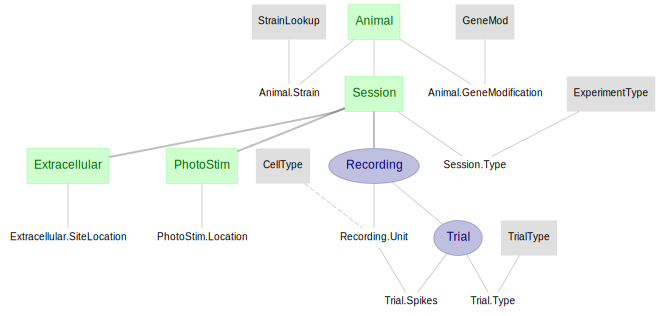

In [13]:
dj.ERD(schema)

In [14]:
# Data migration from the ingest schema
do_ingest = False
if do_ingest:
    # migrate from ingest
    Animal().delete()
    
    ingest = dj.create_virtual_module('ingest', 'tutorial_alm1_ingest')  # for migration
    
    print('Migrating...')
    Animal().insert(ingest.Animal())
    Animal.GeneModification().insert(ingest.Animal.GeneModification())
    Animal.Strain().insert(ingest.Animal.Strain())
    Session().insert(ingest.Session())
    Session.Type().insert(ingest.ExperimentType())
    Extracellular().insert(ingest.Extracellular())
    Extracellular.SiteLocation().insert(ingest.Extracellular.SiteLocation())
    PhotoStim().insert(ingest.PhotoStim())
    PhotoStim.Location().insert(ingest.PhotoStim.Location())
    Recording().insert(ingest.Recording())
    Recording.Unit().insert(ingest.Unit())
    Trial().insert(ingest.Trial())
    Trial.Type().insert(ingest.Trial.Type())
    Trial.Spikes().insert(ingest.Spikes())
    print('done')